In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


In [2]:
pd.options.display.float_format = '{:.5f}'.format

In [3]:
df = pd.read_excel('./최종완료데이터0222.xlsx')

In [31]:
df

,법인코드,업체명,Unfair_duty,총자산증가율,매출액증가율,순이익증가율,영업이익율,부채비율,총자본회전율,납품실적 금액,납품실적 횟수
0,1101115267780,주식회사 한국안전진단기술원,1,2.26188,8.99808,-57.52007,3.27834,56.02967,0.70953,783751500.00000,120
1,1311110342730,효심 주식회사,1,58.84189,-29.55208,-43.19284,1.44195,106.62943,1.40152,8621512610.00000,233
2,1311110304235,주식회사 에스오에스 (s.o.s),1,19.29721,-14.47484,-74.66012,-1.41393,92.10542,2.06820,0.00000,0
3,1101114953041,주식회사 이조건설,1,69.23081,11.47290,112.99718,6.16657,121.07460,4.04692,8324313266.00000,53
4,1650140000227,코스텍유한회사,1,82.52578,1.97895,-32.82040,1.60360,177.60225,0.53763,3161036000.00000,4
...,...,...,...,...,...,...,...,...,...,...,...
1605,1348110177966,착한고기,0,-2.45214,-10.58768,-65.61265,-1.63877,301.68291,1.25138,8865740.00000,3
1606,1648110046751,대광자원,0,-3.73338,-9.33629,-41.93117,1.22787,64.96651,7.32395,0.00000,0
1607,1201110058339,동원금속,0,-0.26279,6.64512,95.13523,3.02774,92.60694,2.00873,465000000.00000,1
1608,1348110207903,우수정밀,0,59.36369,-18.89387,44.93396,14.73077,171.67538,1.00603,0.00000,0


In [370]:
x=df.drop(['Unfair_duty','법인코드','업체명'],axis=1)
y=df['Unfair_duty']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, shuffle=True, stratify=y, random_state=42 )

In [33]:
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, accuracy_score,roc_auc_score
#샘플링 전 모델 돌림
lgb= LGBMClassifier(random_state=42).fit(x_train,y_train)
pred_Y = lgb.predict(x_test)
print(recall_score(y_test, pred_Y))
print(accuracy_score(y_test,pred_Y))
print(f1_score(y_test,pred_Y))
print(precision_score(y_test,pred_Y))
print(roc_auc_score(y_test,pred_Y))

0.603448275862069
0.913151364764268
0.6666666666666665
0.7446808510638298
0.7843328335832084


# Feature selection

In [177]:
# 유니크한 값의 개수를 바탕으로 연속형과 이진형 변수 구분
continuous_cols = [col for col in x_train.columns if len(x_train[col].unique()) > 3]

In [179]:
from sklearn.feature_selection import *
# f_regression(X, Y) => (statistics, p-value)
continous_cols_pvals = f_classif(x_train[continuous_cols], y_train)[1]

In [180]:
# 각각을 Series로 변환 (value: pvalue, index: colum name)
cont_pvals = pd.Series(continous_cols_pvals, index = continuous_cols)

In [181]:
# cont_pvals과 binary_pvals을 합친 뒤, 오름차순으로 정렬 (앞에 나오는 특징부터 좋은 특징)
pvals = pd.concat([cont_pvals])
pvals.sort_values(ascending = True, inplace = True)

In [283]:
# 특징 선택
best_score = 0
for k in range(0,9,1):

    s_Train_X = x_train[pvals.iloc[:k].index]
    s_Test_X = x_test[pvals.iloc[:k].index]
    lgb = LGBMClassifier()
    model = lgb.fit(s_Train_X,y_train)
    pred_Y = model.predict(s_Test_X)
    score = roc_auc_score(y_test,pred_Y)
    if score > best_score:
        best_score = score
    print(best_score, k)

0.5 0
0.6866066966516741 1
0.7310844577711144 2
0.7526736631684158 3
0.7713643178410795 4
0.7713643178410795 5
0.7742628685657171 6
0.7843328335832084 7
0.7843328335832084 8


# EDA

In [371]:
x

,총자산증가율,매출액증가율,순이익증가율,영업이익율,부채비율,총자본회전율,납품실적 금액,납품실적 횟수
0,2.26188,8.99808,-57.52007,3.27834,56.02967,0.70953,783751500.00000,120
1,58.84189,-29.55208,-43.19284,1.44195,106.62943,1.40152,8621512610.00000,233
2,19.29721,-14.47484,-74.66012,-1.41393,92.10542,2.06820,0.00000,0
3,69.23081,11.47290,112.99718,6.16657,121.07460,4.04692,8324313266.00000,53
4,82.52578,1.97895,-32.82040,1.60360,177.60225,0.53763,3161036000.00000,4
...,...,...,...,...,...,...,...,...
1605,-2.45214,-10.58768,-65.61265,-1.63877,301.68291,1.25138,8865740.00000,3
1606,-3.73338,-9.33629,-41.93117,1.22787,64.96651,7.32395,0.00000,0
1607,-0.26279,6.64512,95.13523,3.02774,92.60694,2.00873,465000000.00000,1
1608,59.36369,-18.89387,44.93396,14.73077,171.67538,1.00603,0.00000,0


In [455]:
experiment = pd.concat([x,y],axis=1)
experiment_x = experiment.drop(['Unfair_duty','순이익증가율'],axis=1)

In [456]:
experiment = experiment_x.copy()

In [77]:
plt.rcParams['font.family'] = 'Malgun Gothic'

<AxesSubplot:>

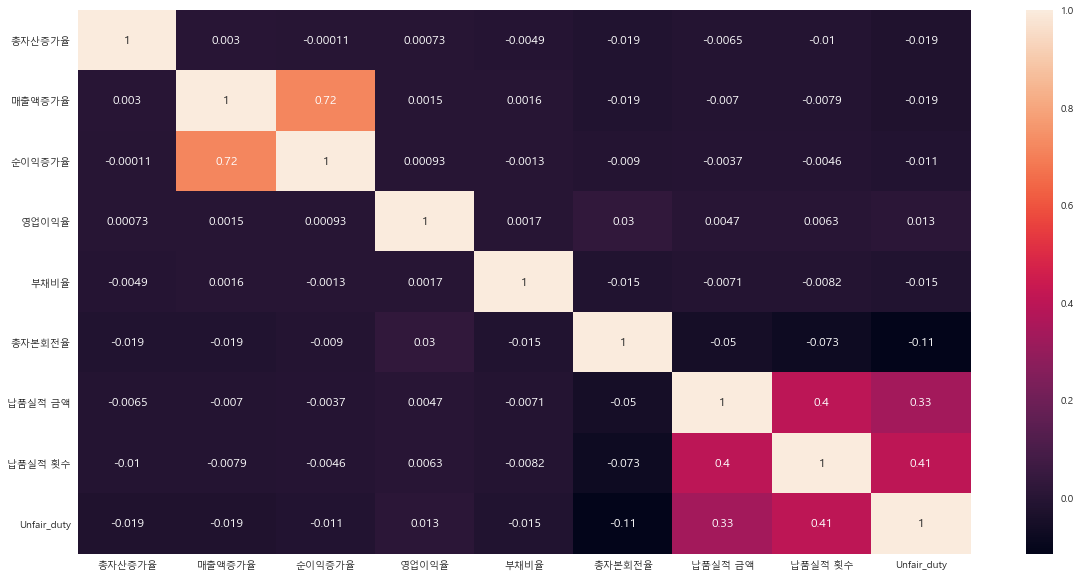

In [78]:
plt.figure(figsize = (20, 10))
corr = experiment.corr()
sns.heatmap(corr, annot = True)

# 단일모델(다중공선성 제거) 실험

In [8]:
#다중공선성 제거
x=df.drop(['Unfair_duty','법인코드','업체명','순이익증가율'],axis=1)
y=df['Unfair_duty']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, shuffle=True, stratify=y, random_state=42 )

In [9]:
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, accuracy_score,roc_auc_score
#다중공선성 제거 후 모델 돌림
lgb= LGBMClassifier(random_state=42).fit(x_train,y_train)
pred_Y = lgb.predict(x_test)
print(recall_score(y_test, pred_Y))
print(accuracy_score(y_test,pred_Y))
print(f1_score(y_test,pred_Y))
print(precision_score(y_test,pred_Y))
print(roc_auc_score(y_test,pred_Y))

0.6379310344827587
0.9156327543424317
0.6851851851851852
0.74
0.8001249375312345


# 로그 정규화 할지안할지 결정하기

In [375]:
numerical_features = []
for i in experiment_x.columns:
    if experiment_x[i].dtype != 'object':
        numerical_features.append(i)

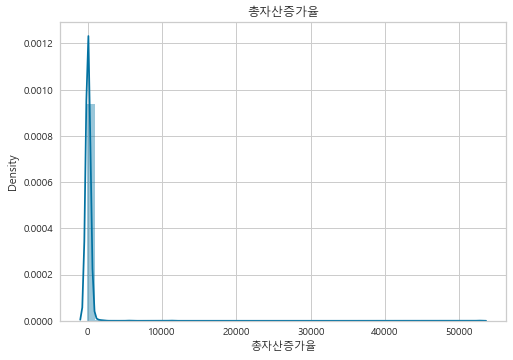

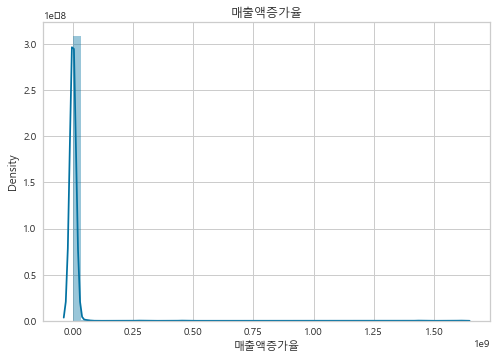

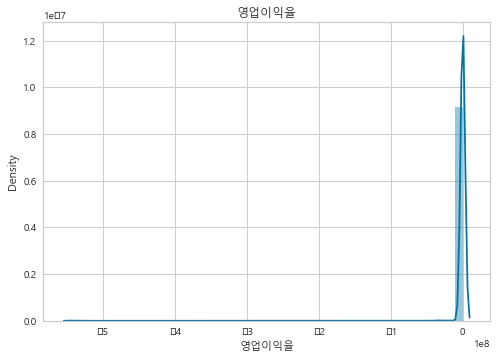

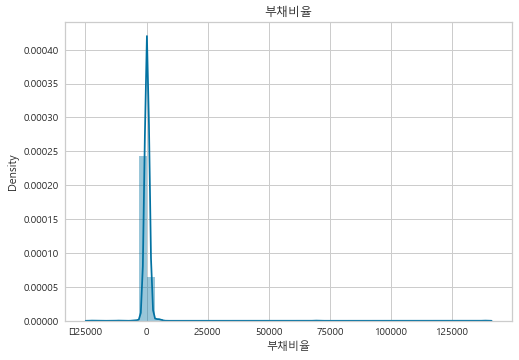

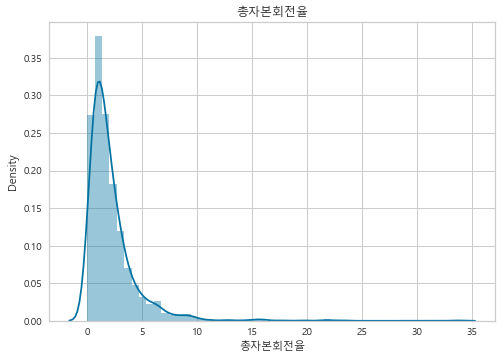

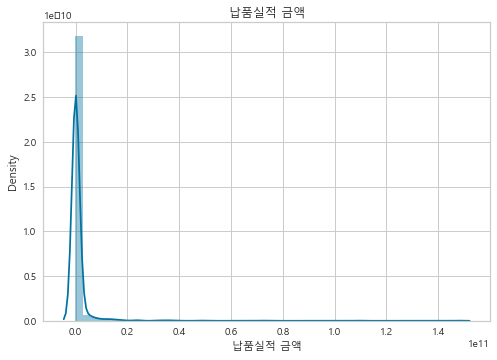

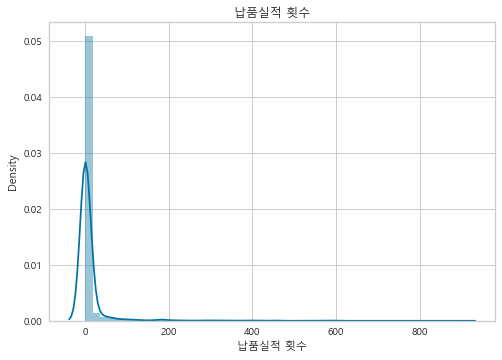

In [376]:
for col in numerical_features:
    sns.distplot(experiment.loc[experiment[col].notnull(), col])
    plt.title(col)
    plt.show()

In [446]:
#변수들 첨도와 왜도
for col in numerical_features: 
    print('{:15}'.format(col), 'Skewness: {:05.2f}'.format(experiment[col].skew()) , ' ' , 'Kurtosis: {:06.2f}'.format(experiment[col].kurt()) )



총자산증가율          Skewness: -1.79   Kurtosis: 059.96
매출액증가율          Skewness: 00.09   Kurtosis: 024.21
영업이익율           Skewness: -40.12   Kurtosis: 1609.99
부채비율            Skewness: -39.56   Kurtosis: 1580.89
총자본회전율          Skewness: 00.44   Kurtosis: 000.06
납품실적 금액         Skewness: -26.30   Kurtosis: 931.47
납품실적 횟수         Skewness: 01.56   Kurtosis: 001.38


In [447]:
experiment_x.columns

Index(['총자산증가율', '매출액증가율', '영업이익율', '부채비율', '총자본회전율', '납품실적 금액', '납품실적 횟수'], dtype='object')

In [452]:
#로그 정규화
for i in ['총자산증가율', '매출액증가율', '영업이익율', '부채비율', '총자본회전율', '납품실적 금액', '납품실적 횟수']:
    #experiment_x[i] = np.where(experiment_x[i]>0, np.log1p(experiment_x[i]), 0)
    experiment_x[i] = np.log(experiment_x[i].values-min(experiment_x[i])+1)

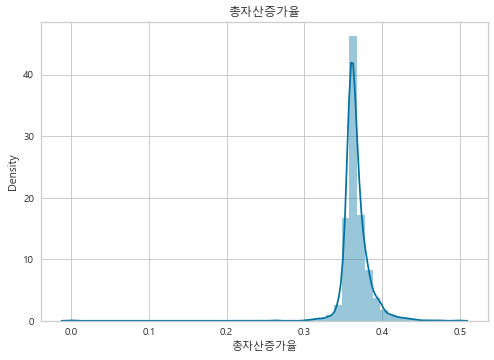

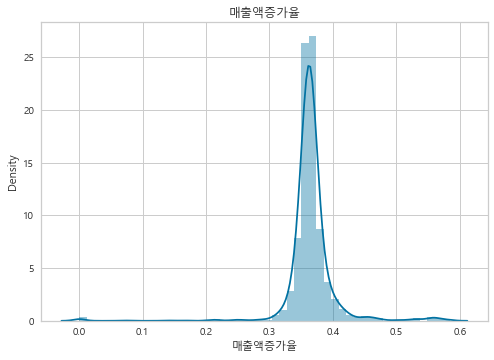

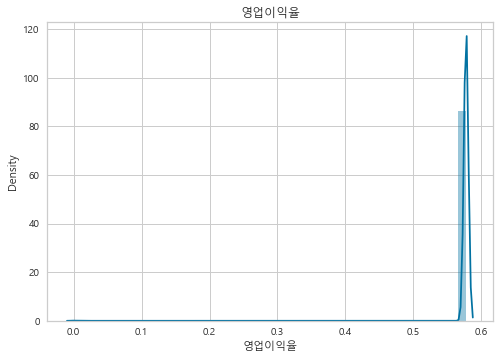

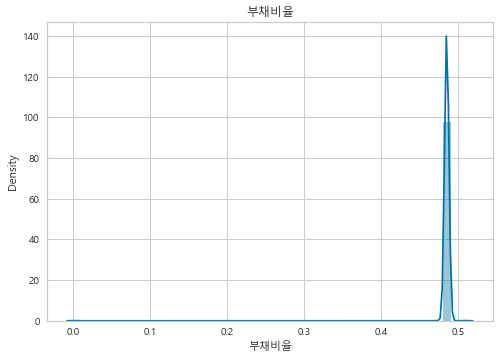

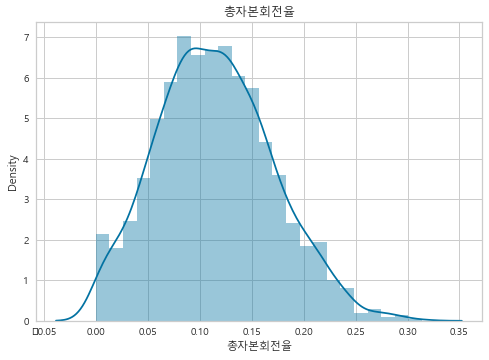

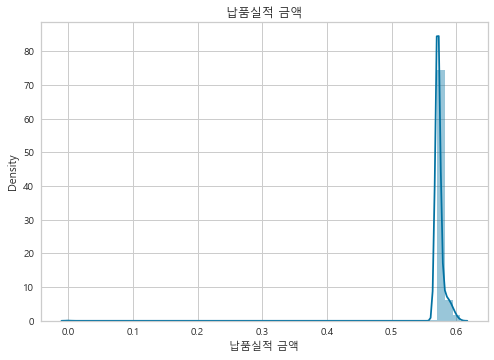

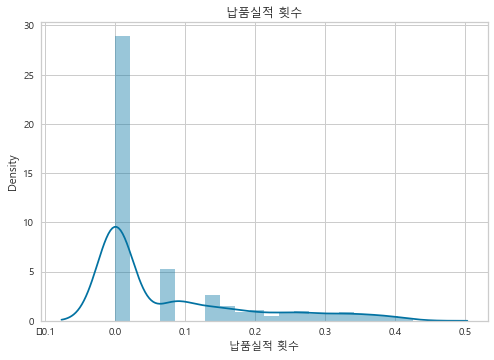

In [453]:
for col in numerical_features:
    sns.distplot(experiment_x.loc[experiment_x[col].notnull(), col])
    plt.title(col)
    plt.show()

In [454]:
for col in numerical_features: 
    print('{:15}'.format(col), 'Skewness: {:05.2f}'.format(experiment_x[col].skew()) , ' ' , 'Kurtosis: {:06.2f}'.format(experiment_x[col].kurt()) )

총자산증가율          Skewness: -3.86   Kurtosis: 102.32
매출액증가율          Skewness: -1.69   Kurtosis: 032.45
영업이익율           Skewness: -40.12   Kurtosis: 1609.99
부채비율            Skewness: -39.78   Kurtosis: 1591.92
총자본회전율          Skewness: 00.29   Kurtosis: -00.15
납품실적 금액         Skewness: -31.17   Kurtosis: 1157.47
납품실적 횟수         Skewness: 01.41   Kurtosis: 000.82


# pycaret

In [37]:
from pycaret.classification import *

In [457]:
df2 = df.drop(['법인코드','업체명','순이익증가율'],axis=1)

In [458]:
clf1 = setup(data=df2, 
             target = 'Unfair_duty',                
             session_id=123, 
             log_experiment=False,  #로그정규화 안함
             experiment_name='experiment1',
             #ignore_features = ['법인코드','업체명'],
             silent=True,
             remove_multicollinearity = True, multicollinearity_threshold = 0.70,
             fold=10# Runs the command without user input. 
            )

,Description,Value
0,session_id,123
1,Target,Unfair_duty
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(1610, 8)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [459]:
compare_models(sort='F1',n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9272,0.8455,0.5979,0.8417,0.6910,0.6519,0.6687,0.0880
rf,Random Forest Classifier,0.9254,0.8542,0.5792,0.8554,0.6767,0.6376,0.6607,0.1130
catboost,CatBoost Classifier,0.9201,0.8506,0.5792,0.8052,0.6624,0.6196,0.6367,1.9560
gbc,Gradient Boosting Classifier,0.9156,0.8445,0.5917,0.7567,0.6560,0.6096,0.6202,0.0710
ada,Ada Boost Classifier,0.9147,0.8276,0.5733,0.7722,0.6491,0.6026,0.6161,0.0450
lightgbm,Light Gradient Boosting Machine,0.9138,0.8407,0.5854,0.7480,0.6490,0.6016,0.6119,0.2870
xgboost,Extreme Gradient Boosting,0.9112,0.8279,0.5850,0.7362,0.6428,0.5938,0.6041,0.1680
knn,K Neighbors Classifier,0.9058,0.7870,0.5221,0.7342,0.6030,0.5521,0.5665,0.0150
dt,Decision Tree Classifier,0.8588,0.7366,0.5662,0.4927,0.5243,0.4420,0.4453,0.0070
lr,Logistic Regression,0.6641,0.8317,0.8108,0.2892,0.4181,0.2617,0.3298,1.2770


[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=123, verbose=0,
                      warm_start=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=-1

In [460]:
ET  = create_model('et')  

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9115,0.7674,0.5625,0.7500,0.6429,0.5935,0.6015
1,0.8938,0.7713,0.4375,0.7000,0.5385,0.4820,0.4991
2,0.9381,0.9501,0.5625,1.0000,0.7200,0.6882,0.7243
3,0.9381,0.8354,0.5625,1.0000,0.7200,0.6882,0.7243
4,0.9115,0.7242,0.5000,0.8000,0.6154,0.5684,0.5884
5,0.9735,0.9910,0.9375,0.8824,0.9091,0.8936,0.8941
6,0.9464,0.8361,0.6667,0.9091,0.7692,0.7397,0.7511
7,0.9375,0.8516,0.6250,0.9091,0.7407,0.7066,0.7226
8,0.9375,0.9320,0.7500,0.8000,0.7742,0.7380,0.7385
9,0.8839,0.7959,0.3750,0.6667,0.4800,0.4204,0.4425


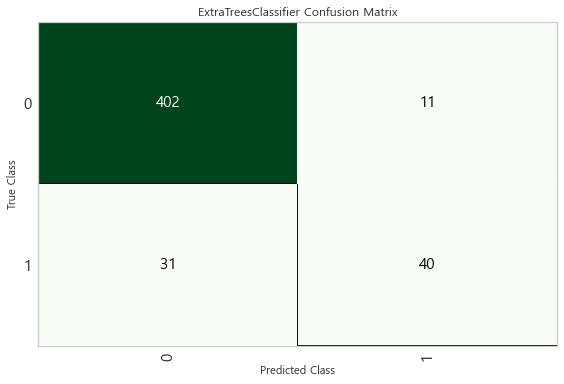

In [461]:
plot_model(estimator = ET, plot = 'confusion_matrix')

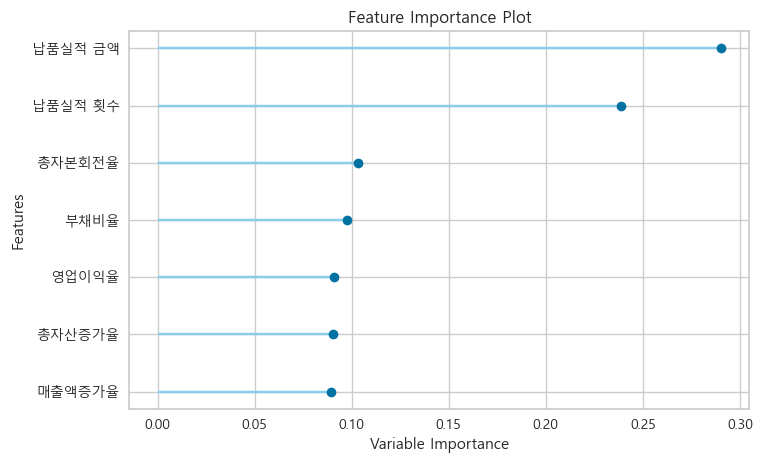

In [462]:
plot_model(estimator = ET, plot = 'feature')

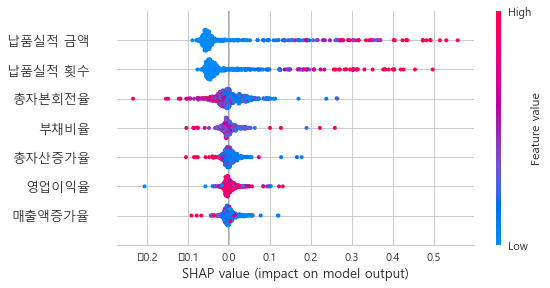

In [463]:
interpret_model(ET)